In [30]:
# 기본 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

'''
[Step 1] 데이터 준비 - Seaborn에서 제공하는 titanic 데이터셋 가져오기
'''

# load_dataset 함수를 사용하여 데이터프레임으로 변환
df = sns.load_dataset('titanic')


'''
[Step 2 ~ 3] 데이터 전처리
'''

# 중복 데이터 제거
df = df.drop_duplicates()

# NaN값이 많은 deck 열을 삭제, embarked와 내용이 겹치는 embark_town 열을 삭제
rdf = df.drop(['deck', 'embark_town'], axis=1)  

# age 열에 나이 데이터가 없는 모든 행을 삭제 - NaN 값
rdf = rdf.dropna(subset=['age'], how='any', axis=0)  

# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기
most_freq = rdf['embarked'].mode()[0]    
rdf['embarked'] = rdf['embarked'].fillna(most_freq)

'''
[Step 4] 변수 선택
'''

# 분석에 활용할 열(속성)을 선택 
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]

# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변환
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

ndf = ndf.drop(['sex', 'embarked'], axis=1)


'''
[Step 5] 데이터셋 구분 - 훈련용(train data)/ 검증용(test data)
'''

# 속성(변수) 선택
X = ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 
       'town_C', 'town_Q', 'town_S']]  #독립 변수 X
y = ndf['survived']                      #종속 변수 Y

# 설명 변수 데이터를 정규화(normalization)
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 

print('train data 개수: ', X_train.shape)
print('test data 개수: ', X_test.shape)

train data 개수:  (474, 9)
test data 개수:  (204, 9)


In [31]:
'''
[Step 6] SVM 분류 모형 - sklearn 사용
'''

# sklearn 라이브러리에서 SVM 분류 모형 가져오기
from sklearn import svm

# 모형 객체 생성 (kernel='rbf' 적용)
svm_model = svm.SVC(kernel='rbf')

# train data를 가지고 모형 학습
svm_model.fit(X_train, y_train)   

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = svm_model.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

[1 1 0 1 0 0 0 1 1 1]
[1 1 0 1 0 1 1 1 1 0]


In [32]:
# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
svm_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(svm_matrix)

[[104  19]
 [ 24  57]]


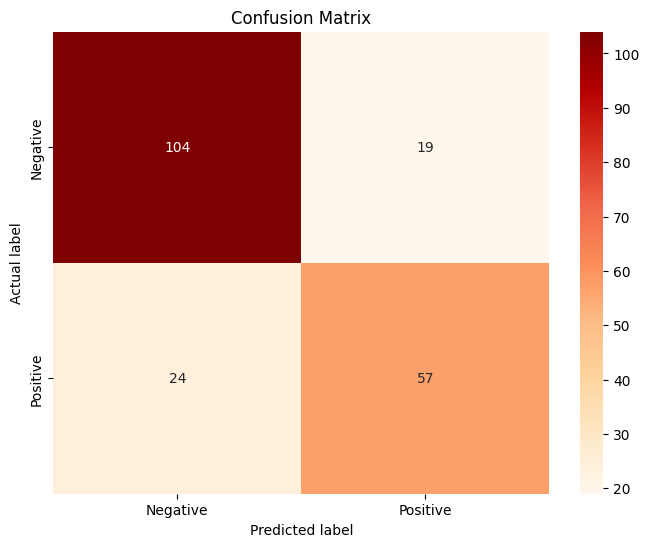

In [33]:
# Confusion Matrix 시각화

plt.figure(figsize=(8, 6))
sns.heatmap(svm_matrix, annot=True, fmt='d', cmap='OrRd', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])

plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [34]:
# 모형 성능 평가 - 평가지표 계산
svm_report = metrics.classification_report(y_test, y_hat)            
print(svm_report)

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       123
           1       0.75      0.70      0.73        81

    accuracy                           0.79       204
   macro avg       0.78      0.77      0.78       204
weighted avg       0.79      0.79      0.79       204



In [35]:
# 동일한조건에 knn을 학습을 하면 classification_report가 어떻게 나오는지 확인
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
predict = knn.predict(X_test)
print(metrics.classification_report(y_test, y_hat)  )

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       123
           1       0.75      0.70      0.73        81

    accuracy                           0.79       204
   macro avg       0.78      0.77      0.78       204
weighted avg       0.79      0.79      0.79       204



In [36]:
# 동일한조건에 knn을 학습을 하면 classification_report가 어떻게 나오는지 확인
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
predict = knn.predict(X_test)
print(metrics.classification_report(y_test, y_hat)  )

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       123
           1       0.75      0.70      0.73        81

    accuracy                           0.79       204
   macro avg       0.78      0.77      0.78       204
weighted avg       0.79      0.79      0.79       204



In [37]:
### 지도학습 : 정답 O
'''
SVM : Surport Vector Machine
분류와 회귀 가능하지만, 둘 중 분류에 특화된 모델
하이퍼 플레인 : 데이터를 두 클래스로 나누는 "경계"
서포트 벡터 : 하이퍼 플레인에 가장 가까운 데이터 포인트들 / 이 포인트들이 결정경계에 영향을 줌
마진 : 하이퍼 플레인과 서포트 벡터 사이의 거리 / svm이  마진을 최대화 -> 성능을 높임

'''

'\nSVM : Surport Vector Machine\n분류와 회귀 가능하지만, 둘 중 분류에 특화된 모델\n하이퍼 플레인 : 데이터를 두 클래스로 나누는 "경계"\n서포트 벡터 : 하이퍼 플레인에 가장 가까운 데이터 포인트들 / 이 포인트들이 결정경계에 영향을 줌\n마진 : 하이퍼 플레인과 서포트 벡터 사이의 거리 / svm이  마진을 최대화 -> 성능을 높임\n\n'

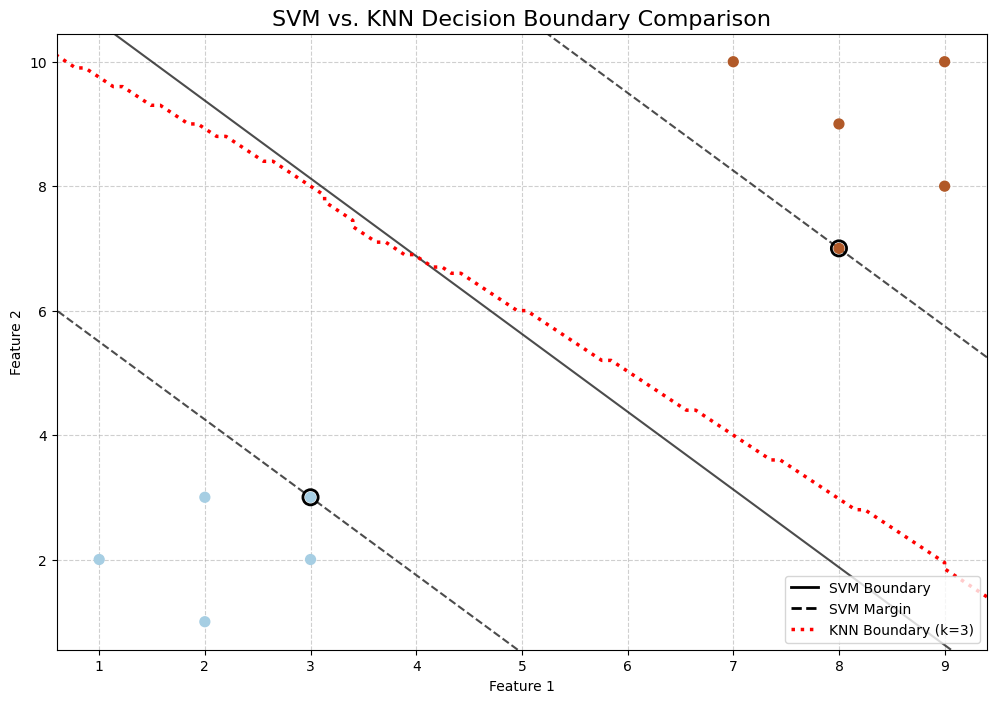

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

# 1. 샘플 데이터 생성
X = np.array([[1, 2], [2, 3], [3, 3], [2, 1], [3, 2], # 클래스 0
              [8, 9], [7, 10], [9, 10], [8, 7], [9, 8]]) # 클래스 1
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

# 2. SVM 모델 생성 및 학습
clf_svm = svm.SVC(kernel='linear', C=1000)
clf_svm.fit(X, y)

# 3. KNN 모델 생성 및 학습 (n_neighbors=3, 즉 k=3)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn.fit(X, y)

# 4. 시각화
plt.figure(figsize=(12, 8))

# 학습 데이터 포인트(산점도) 그리기
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=plt.cm.Paired, zorder=3)
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
plt.title('SVM vs. KNN Decision Boundary Comparison', fontsize=16)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# 그래프의 축 범위 가져오기
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# 결정 경계를 그리기 위한 그리드 생성
xx = np.linspace(xlim[0], xlim[1], 100)
yy = np.linspace(ylim[0], ylim[1], 100)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

# --- SVM 결정 경계 계산 및 그리기 ---
Z_svm = clf_svm.decision_function(xy).reshape(XX.shape)
# SVM 결정 경계(실선), 마진(점선)
ax.contour(XX, YY, Z_svm, colors='k', levels=[-1, 0, 1], alpha=0.7,
           linestyles=['--', '-', '--'])
# 서포트 벡터 강조
ax.scatter(clf_svm.support_vectors_[:, 0], clf_svm.support_vectors_[:, 1], s=120,
           linewidth=2, facecolors='none', edgecolors='k', zorder=4)

# --- KNN 결정 경계 계산 및 그리기 ---
Z_knn = clf_knn.predict(xy).reshape(XX.shape)
# KNN 결정 경계를 빨간색 점선으로 그립니다.
ax.contour(XX, YY, Z_knn, colors='r', levels=[0.5], linestyles=[':'], linewidths=2.5)

# 가짜 선을 만들어 범례에 추가
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='k', lw=2, label='SVM Boundary'),
                   Line2D([0], [0], color='k', lw=2, ls='--', label='SVM Margin'),
                   Line2D([0], [0], color='r', lw=2.5, ls=':', label='KNN Boundary (k=3)')]
ax.legend(handles=legend_elements, loc='lower right')


plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

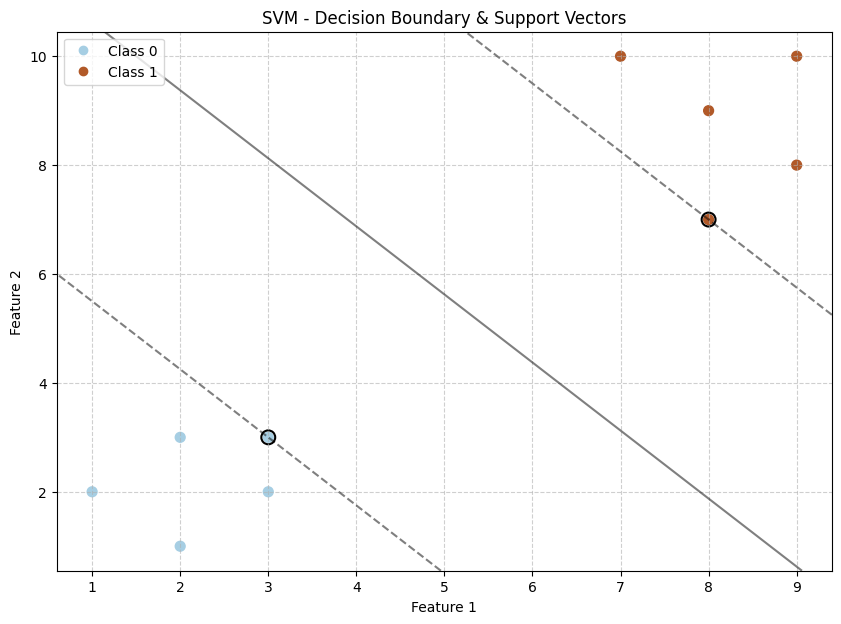

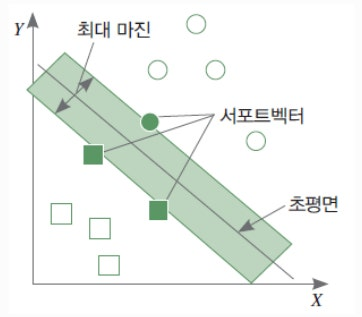

In [39]:
#  iris 붓꽃의 품종이 2가지
from sklearn.datasets import load_iris
iris = load_iris()
print (iris.keys())
iris.data

# data target feature_names target_names
# 붓꽃의 품종을 분류하는 모델
# svm, knn
# 학습결과를 시각화
X = iris.data
y = iris.target


dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


In [40]:
# 모델 선택
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()

# 모델별 학습
knn =  KNeighborsClassifier()
svm = SVC()

knn.fit(x_train,y_train)
svm.fit(x_train,y_train)

# 예측
knn_predict = knn.predict(x_test)
svm_predict = svm.predict(x_test)

print(classification_report(y_test, knn_predict))
print(classification_report(y_test, svm_predict))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [41]:
# svm large 마진 : 가장 안정적으로 데이터를 나눌 수 있는 최적의 경계선
from sklearn.svm import SVC
from sklearn.datasets import load_iris
import seaborn as sns

iris = load_iris()
X = iris.data[:, [2,3]]
y = iris.target

# 품종은 setosa versicolor   0 또는 1
mask = (y == 0) | (y == 1)
X = X[mask]
y = y[mask]

# C는 규제 / Regularization 마진을 얼마나 깨끗하게 유지할지 결정 / inf(무한대)로 설정 
# 마진오류 허용X ->하드마진 / 모든 데이터를 완벽하게 직선으로 나누려는 시도
svm_clf = SVC(kernel='linear', C=float('inf'))  # 선형분류기 모델
svm_clf.fit(X,y)

,C,inf
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


SVC(C=inf, kernel='linear')

In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.
On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

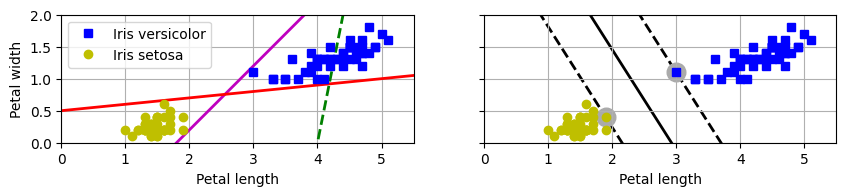

In [42]:
import numpy as np
from sklearn.svm import SVC
from sklearn import datasets
from matplotlib.pylab import plt

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM 분류 모델
svm_clf = SVC(kernel="linear", C=10**9)
svm_clf.fit(X, y)

# 나쁜 모델
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5 * x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # 결정 경계에서, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svs = svm_clf.support_vectors_

    plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#AAA',
                zorder=-1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

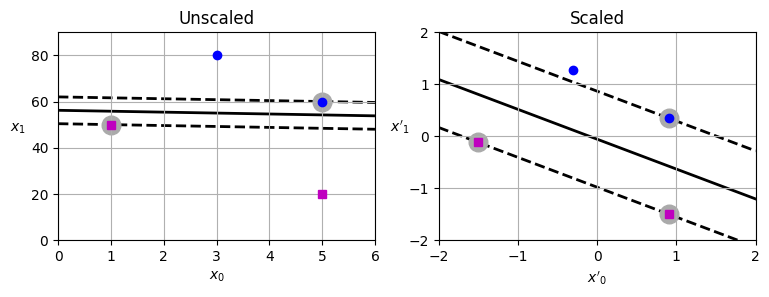

In [43]:
# 스케일에 민감
# 스케일이 다른 가상의 데이터를생성
from sklearn.preprocessing import StandardScaler
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100).fit(Xs, ys)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf_scaled = SVC(kernel="linear", C=100).fit(X_scaled, ys)

plt.figure(figsize=(9, 2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$")
plt.ylabel("$x_1$    ", rotation=0)
plt.title("Unscaled")
plt.axis([0, 6, 0, 90])
plt.grid()

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf_scaled, -2, 2)
plt.xlabel("$x'_0$")
plt.ylabel("$x'_1$  ", rotation=0)
plt.title("Scaled")
plt.axis([-2, 2, -2, 2])
plt.grid()


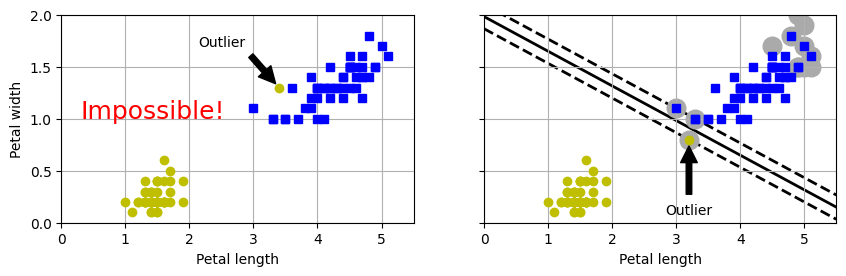

In [44]:
iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", color="red", fontsize=18)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.annotate(
    "Outlier",
    xy=(X_outliers[0][0], X_outliers[0][1]),
    xytext=(2.5, 1.7),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
)
plt.axis([0, 5.5, 0, 2])
plt.grid()

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length")
plt.annotate(
    "Outlier",
    xy=(X_outliers[1][0], X_outliers[1][1]),
    xytext=(3.2, 0.08),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
)
plt.axis([0, 5.5, 0, 2])
plt.grid()


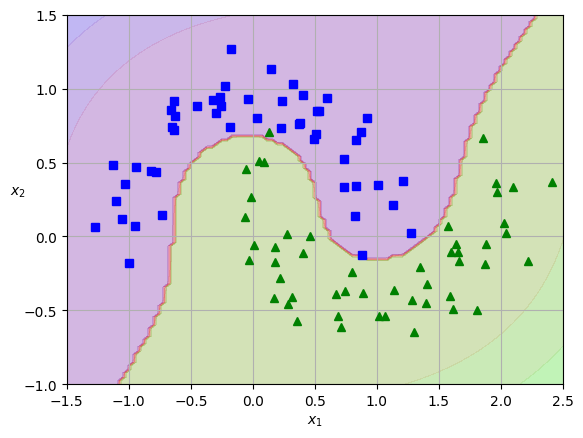

In [45]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

polynomial_svm_clf = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    LinearSVC(C=10, max_iter=10_000, dual=True, random_state=42)
)
polynomial_svm_clf.fit(X, y)
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

[1.]


c:\anaconda\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


NameError: name 'plot_svc_decision_boundary' is not defined

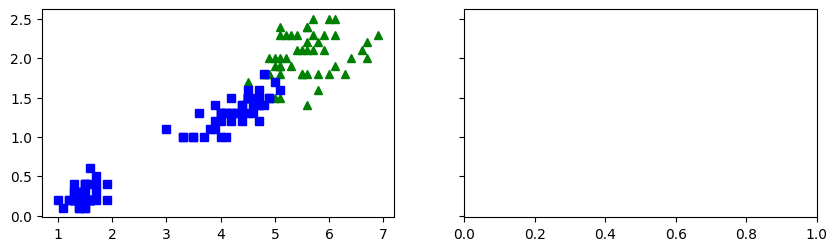

In [3]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris.data[:,[2,3] ]  # 꽃잎의 길이 너비
y = (iris.target == 2).astype(float)

svm_clf =  Pipeline([
    ('scaler',StandardScaler()),
    ('linear_svc',LinearSVC(random_state=42))
])
svm_clf.fit(X,y)

# 예측
print( svm_clf.predict( [[5.5, 1.7]] ) )
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

# 스케일되지 않은 파라미터로 변환
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# 서포트 벡터 찾기 (그림 표시용)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]


# 시각화
fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 6)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.title("$C = {}$".format(svm_clf1.C))
plt.axis([4, 6, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length")
plt.title("$C = {}$".format(svm_clf2.C))
plt.axis([4, 6, 0.8, 2.8])

plt.show()

In [47]:
# SVM 에서의 C는 규제 / Regularization 마진을 얼마나 깨끗하게 유지할지 결정 / inf(무한대)로 설정 
# 마진오류 허용X ->하드마진 / 모든 데이터를 완벽하게 직선으로 나누려는 시도
# 예) svm_clf = SVC(kernel='linear', C=float('inf'))  # 선형분류기 모델
'''
C=1 : 마진이 넓게 만드는 것을 우선시 / 약간의 오류 허용
C=100 : 마진이 좁아도 좋으니 오류 허용 X 
*** C값이 클수록 더 엄격하게 오류 제한 ***

'''

'\nC=1 : 마진이 넓게 만드는 것을 우선시 / 약간의 오류 허용\nC=100 : 마진이 좁아도 좋으니 오류 허용 X \n*** C값이 클수록 더 엄격하게 오류 제한 ***\n\n'

In [2]:
# 비선형
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.svm import SVC
X,y = make_moons(n_samples=1000, noise=0.15,random_state=42)
ploynomial_svm_clf =  Pipeline([
    ('poly_reatures', PolynomialFeatures(degree=3)),
    ('scaler',StandardScaler()),
    ('svm_clf',LinearSVC(C=100,random_state=42))
])
ploynomial_svm_clf.fit(X,y)


NameError: name 'StandardScaler' is not defined

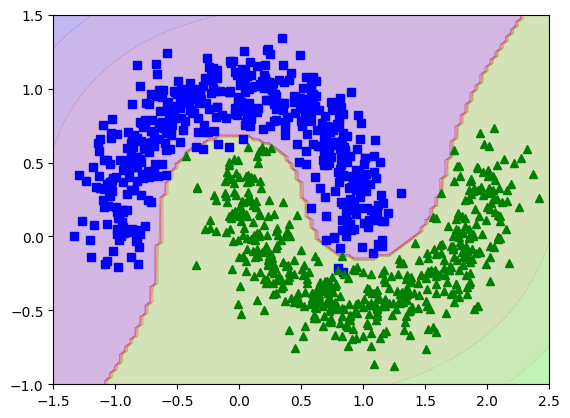

In [49]:
plt.plot(X[:,0][y==0], X[:,1][y==0], 'bs')
plt.plot(X[:,0][y==1], X[:,1][y==1], 'g^')
plot_predictions(polynomial_svm_clf,[-1.5,2.5,-1,1.5])

In [1]:
# 커널 트릭  : 실제로 데이터를 고차원으로 변환하지 않으면서 동일한효과를 발생
from sklearn.svm import SVC
poly_kernel = Pipeline([
    ('scaler',StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=3, C=5))
])
poly_kernel.fit(X,y)

poly_kernel_100 = Pipeline([
    ('scaler',StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=10,coef0=100,C=5))  # coef0 모델이 높은 차수와 낮은차수에 영향을 받을지 조정 크면 고차항의 영향을 더 많이 받는다
])
poly_kernel_100.fit(X,y)

fig, ax = plt.subplots(1,2,figsize=(10,6))
plt.sca(ax[0])
plot_predictions(poly_kernel,[-1.5,2.5,-1,1.5])
plt.sca(ax[1])
plot_predictions(poly_kernel_100,[-1.5,2.5,-1,1.5])

NameError: name 'Pipeline' is not defined